In [ ]:
# Install required libraries
!pip install --upgrade pgeocode
!pip install --upgrade geopandas
!pip install --upgrade -q gspread

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 7.6 MB/s 
     |████████████████████████████████| 16.7 MB 348 kB/s 
     |████████████████████████████████| 6.3 MB 41.1 MB/s 


In [ ]:
# Import packages
import os
import pandas as pd
import numpy as np
from statistics import mean, stdev
import pgeocode
import geopandas
import matplotlib.pyplot as plt
import seaborn as sns
import folium

**1 Data Extraction**

In [ ]:
# Code section to read data from the sheet in this link
# https://drive.google.com/file/d/1q0vBXy-Qud5Qb4ApCCO26auCaJbNbabR/view?usp=sharing

!pip install -U -q PyDrive
 
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
 
 
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

link = 'https://drive.google.com/file/d/1q0vBXy-Qud5Qb4ApCCO26auCaJbNbabR/view?usp=sharing'
 
# import pandas as pd
 
# to get the id part of the file
id = link.split("/")[-2]
id
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('customers_my.csv') 
 
dataset = pd.read_csv('customers_my.csv')
print(df)

                             customer  postcode country
0                   Shin-Etsu Polymer     40000      MY
1                    Putra Glass Hall     40400     NaN
2                       Istana Bandar     42700     NaN
3                  Forest Valley Hall     43200     NaN
4             The Mines Shopping Mall     43300     NaN
5          Xiamen University Malaysia     43900     NaN
6                Hammock by The River     47310     NaN
7       Subang Jaya Industrial Estate     47500     NaN
8     Thomson Hospital Kota Damansara     47810     NaN
9                          Mont Kiara     50480     NaN
10            Decathlon Sri Damansara     52200     NaN
11      Royal Selangor Visitor Centre     53300     NaN
12               Sunway Velocity Mall     55100     NaN
13     Mitsui Outlet Park KLIA Sepang     64000     NaN
14                 Bandar Baru Enstek     71760     NaN
15  Kota Seriemas Golf & Country Club     71800     NaN


In [ ]:
# Extract required columns
df_customer = dataset.loc[:, ('customer','postcode')]

# Extract country code
country = str(dataset.loc[0, ('country')]).upper()

**2 Display Input Data**

In [ ]:
print('Country code: ', country)
print('')
df_customer

Country code:  MY



,customer,postcode
0,Shin-Etsu Polymer,40000
1,Putra Glass Hall,40400
2,Istana Bandar,42700
3,Forest Valley Hall,43200
4,The Mines Shopping Mall,43300
5,Xiamen University Malaysia,43900
6,Hammock by The River,47310
7,Subang Jaya Industrial Estate,47500
8,Thomson Hospital Kota Damansara,47810
9,Mont Kiara,50480


**3 Generate geographical information based on Postcode**

In [ ]:
# Generate location information by pgeocode library
nomi = pgeocode.Nominatim(country)
df_location = nomi.query_postal_code(df_customer.postcode.astype(str).tolist())
df_location.head()

# Resulted table contains generated country code, place name, state name, state code, latitude and longitude

,postal_code,country_code,place_name,state_name,state_code,county_name,county_code,community_name,community_code,latitude,longitude,accuracy
0,40000,MY,Shah Alam,Selangor,SGR,NaN,NaN,NaN,NaN,3.0797,101.5186,3.0
1,40400,MY,Shah Alam,Selangor,SGR,NaN,NaN,NaN,NaN,3.0457,101.5573,3.0
2,42700,MY,Banting,Selangor,SGR,NaN,NaN,NaN,NaN,2.9092,101.5279,3.0
3,43200,MY,Cheras,Selangor,SGR,NaN,NaN,NaN,NaN,3.0643,101.7543,3.0
4,43300,MY,Seri Kembangan,Selangor,SGR,NaN,NaN,NaN,NaN,3.0383,101.7094,3.0


**4 K-Means Clustering**

Run K-Means algorithm on customers coordinates (latitude, longitude) in order to segment customers' location.

In [ ]:
# Import required libraries
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

In [ ]:
# Create dataframe for clustering that consists of latitude & longitude values
# Remove customer location with unrecognized postcodes
df_location2 = df_location.dropna(subset=['latitude','longitude'])
df_cluster   = df_location2[['latitude','longitude']]

# Scale latitude & longitude by Standard Scaler
df_cluster = StandardScaler().fit_transform(df_cluster)
df_cluster

array([[ 0.41698443, -1.68568015],
       [ 0.16342289, -1.25168125],
       [-0.85455208, -1.58138584],
       [ 0.30213597,  0.95756382],
       [ 0.10823597,  0.45403537],
       [-0.3526494 ,  0.42375638],
       [ 0.48335788, -0.76217086],
       [ 0.89651403, -0.9130051 ],
       [ 1.03821018,  0.0716229 ],
       [ 0.98078595, -0.02369985],
       [ 1.08892248,  0.4394566 ],
       [ 0.84132711,  0.72710703],
       [-1.49069322,  0.20283187],
       [-2.02242667,  1.0966229 ],
       [-1.59957552,  1.84462617]])

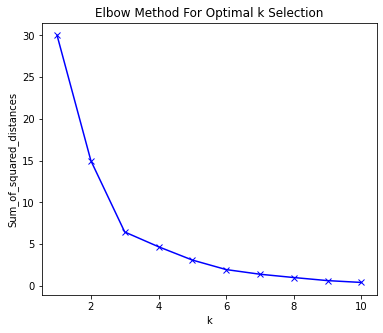

In [ ]:
# Displaying elbow method for identification of optimal K no. of clusters
# Optimal K is identified at K where the elbow occurs in the Elbow plot
Sum_of_squared_distances = []
K = range(1,11)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(df_cluster)
    Sum_of_squared_distances.append(km.inertia_)
    
plt.figure(figsize=(6,5))
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k Selection')
plt.show()

In [ ]:
# Generate Silhouette Scoring to reconfirm the finding from Elbow plot
k = 10  # Specify predefined no. of K to be evaluated
i = 2   # Initialize K to be evaluated at K=2 (K=1 is invalid)

df_array = df_cluster.copy()

# Initialize a df to store the Silhouette scores
df_clusterscore = pd.DataFrame()

while i <= k:
    # Run clustering
    model = KMeans(n_clusters=i) 
    model.fit(df_array)
    print('Cluster k=', i)
    print('Sil score = ' + str(round(silhouette_score(df_array, model.labels_),4)))
    print()
    
    df_clusterscore.loc[i,'Sil_score'] = round(silhouette_score(df_array, model.labels_),4)
    
    i += 1


Cluster k= 2
Sil score = 0.4768

Cluster k= 3
Sil score = 0.4951

Cluster k= 4
Sil score = 0.4385

Cluster k= 5
Sil score = 0.418

Cluster k= 6
Sil score = 0.3826

Cluster k= 7
Sil score = 0.3677

Cluster k= 8
Sil score = 0.3401

Cluster k= 9
Sil score = 0.2966

Cluster k= 10
Sil score = 0.2866



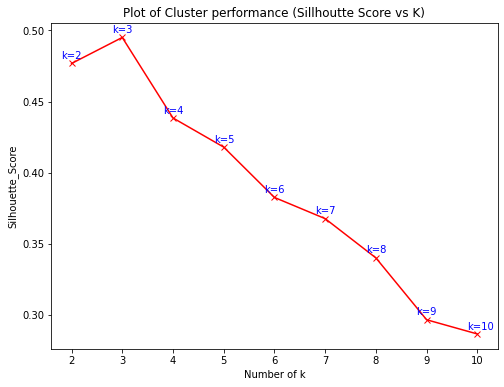

In [ ]:
# Generate plot for the Silhouette Score to ease understanding of the optimal K

x = df_clusterscore.index.to_numpy()
y = df_clusterscore.Sil_score.to_numpy()

fig = plt.figure(figsize=(8,6))
ax  = fig.add_subplot(111)
#ax.set_ylim(0.5,1.1)
#pyplot.scatter(x, y, marker='o', color="blue" )
plt.plot(x, y, 'rx-')

a = df_clusterscore.index[0]
while a< len(df_clusterscore.index):
    for i,j in zip(x,y):
        ax.annotate(('k='+str(a)), xy=(i,j), 
                    color="blue",
                    textcoords="offset points", # how to position the text
                    xytext=(-10,5)) # distance from text to points (x,y)
        a+=1    

plt.title('Plot of Cluster performance (Sillhoutte Score vs K)')
plt.xlabel('Number of k')
plt.ylabel('Silhouette_Score')
plt.show()

In [ ]:
# Obtain the optimal no. of K by sorting the df_clusterscore in descending order
# and extract K at the top of the table
df_clusterscore.sort_values(by=['Sil_score'], inplace=True, ascending=False)
K = df_clusterscore.index[0]
print('Optimal K : ', K)

Optimal K :  3


**5 Fit cluster number, K to customer table**

In [ ]:
# Generate clusters for all customers location
model = KMeans(n_clusters = K) # Obtain optimized K from Silhouette score assessment 
model.fit(df_cluster)
labels = model.predict(df_cluster)
labels = labels+1 # Adjust K to start from 1 instead of 0
df_location2['segment'] = labels
df_location2.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,postal_code,country_code,place_name,state_name,state_code,county_name,county_code,community_name,community_code,latitude,longitude,accuracy,segment
0,40000,MY,Shah Alam,Selangor,SGR,NaN,NaN,NaN,NaN,3.0797,101.5186,3.0,2
1,40400,MY,Shah Alam,Selangor,SGR,NaN,NaN,NaN,NaN,3.0457,101.5573,3.0,2
2,42700,MY,Banting,Selangor,SGR,NaN,NaN,NaN,NaN,2.9092,101.5279,3.0,2
3,43200,MY,Cheras,Selangor,SGR,NaN,NaN,NaN,NaN,3.0643,101.7543,3.0,1
4,43300,MY,Seri Kembangan,Selangor,SGR,NaN,NaN,NaN,NaN,3.0383,101.7094,3.0,1


**6 Prepare list to be used for visualization**

In [ ]:
# 
gdf = geopandas.GeoDataFrame(
    df_location2, geometry=geopandas.points_from_xy(df_location2.longitude, df_location2.latitude))

# Create a geometry list from the GeoDataFrame for the map visualization purpose
geo_df_list = [[point.xy[1][0], point.xy[0][0]] for point in gdf.geometry ]
# Display snippet of Top 5
geo_df_list[0:5]

[[3.0797, 101.5186],
 [3.0457, 101.5573],
 [2.9092, 101.5279],
 [3.0643, 101.7543],
 [3.0383, 101.7094]]

In [ ]:
geo_df_list = df_location2[['latitude','longitude']].values.tolist()

In [ ]:
type(geo_df_list[0][1])

float

In [ ]:
# Set color hues to display map's popup icons
# Empty color ('') at the 0 position due to cluster no. starts with K=1
colors = ['', 'blue', 'green', 'purple', 'orange', 'red',
          'darkred', 'lightred', 'beige', 'darkblue', 'darkgreen', 
          'cadetblue', 'darkpurple', 'white', 'pink', 'lightblue', 
          'lightgreen', 'gray', 'black', 'lightgray']

**7 Display result table**

The result contains the initial customer name & postcode, together with the additional derived information on customer location & the location segment based on K-Means clustering.

In [ ]:
# Concatenate customer name & postcode in df_customer with the geographical info in df_location table
# Concatenate with df_location2 to obtain 'segment' (cluster number) information
df_customer2 = df_customer.copy().reset_index(drop=True)
df_customer2 = pd.concat([df_customer2,df_location[['country_code','place_name','state_name','state_code',
                                   'latitude','longitude']]], axis=1)
df_customer2 = pd.concat([df_customer2, df_location2[['segment']]], axis=1)
df_customer2

,customer,postcode,country_code,place_name,state_name,state_code,latitude,longitude,segment
0,Shin-Etsu Polymer,40000,MY,Shah Alam,Selangor,SGR,3.0797,101.51860,2.0
1,Putra Glass Hall,40400,MY,Shah Alam,Selangor,SGR,3.0457,101.55730,2.0
2,Istana Bandar,42700,MY,Banting,Selangor,SGR,2.9092,101.52790,2.0
3,Forest Valley Hall,43200,MY,Cheras,Selangor,SGR,3.0643,101.75430,1.0
4,The Mines Shopping Mall,43300,MY,Seri Kembangan,Selangor,SGR,3.0383,101.70940,1.0
5,Xiamen University Malaysia,43900,MY,Sepang,Selangor,SGR,2.9765,101.70670,1.0
6,Hammock by The River,47310,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Subang Jaya Industrial Estate,47500,MY,"Petaling Jaya, Subang Jaya",Selangor,SGR,3.0886,101.60095,2.0
8,Thomson Hospital Kota Damansara,47810,MY,Petaling Jaya,Selangor,SGR,3.1440,101.58750,2.0
9,Mont Kiara,50480,MY,Kuala Lumpur,Kuala Lumpur,KUL,3.1630,101.67530,1.0


**8 Visualize Customer Segmentation on Python Folium Map**

In [ ]:
# Prepare dataframe without null values for map visualization
df_map = df_customer2.dropna(subset=['segment']).reset_index(drop=True)
df_map['segment'] = df_map['segment'].astype('int')

,customer,postcode,country_code,place_name,state_name,state_code,latitude,longitude,segment
0,Shin-Etsu Polymer,40000,MY,Shah Alam,Selangor,SGR,3.0797,101.51860,2
1,Putra Glass Hall,40400,MY,Shah Alam,Selangor,SGR,3.0457,101.55730,2
2,Istana Bandar,42700,MY,Banting,Selangor,SGR,2.9092,101.52790,2
3,Forest Valley Hall,43200,MY,Cheras,Selangor,SGR,3.0643,101.75430,1
4,The Mines Shopping Mall,43300,MY,Seri Kembangan,Selangor,SGR,3.0383,101.70940,1
5,Xiamen University Malaysia,43900,MY,Sepang,Selangor,SGR,2.9765,101.70670,1
6,Subang Jaya Industrial Estate,47500,MY,"Petaling Jaya, Subang Jaya",Selangor,SGR,3.0886,101.60095,2
7,Thomson Hospital Kota Damansara,47810,MY,Petaling Jaya,Selangor,SGR,3.1440,101.58750,2
8,Mont Kiara,50480,MY,Kuala Lumpur,Kuala Lumpur,KUL,3.1630,101.67530,1
9,Decathlon Sri Damansara,52200,MY,Kuala Lumpur,Kuala Lumpur,KUL,3.1553,101.66680,1


In [ ]:
# Initialize folium map with tiles theme OpenStreetMap
map = folium.Map(location = [mean(df_location2.latitude),mean(df_location2.longitude)], tiles='OpenStreetMap' , width=600, height=400, zoom_start = 9)
# map

# Iterate through the row of customers and add a marker (pop-up) icon at their locations, 
# The popup icons are color-coded by their location segment number (e.g. 1, 2, .., n).
i = 0 

for coordinates in geo_df_list:
    # Assign type_color based on the value of the segment (K) in df_location.segment
    # K will be the index for tab20 color hue selection to differentiate colors between segments
    type_color = colors[df_map.segment[i]] 
                                                         
    # Place the markers with the popup labels and data
    map.add_child(folium.Marker(location = coordinates,
                            popup = 
                            str(df_map.customer[i]) + '<br>' +
                            "City: "     + str(df_map.place_name[i]) + '<br>' + 
                            "Segment: "    + str(df_map.segment[i]) + '<br>' +
                            "Coordinates: " + str(df_map.latitude[i]) +', ' + str(df_map.longitude[i]),
                            icon = folium.Icon(icon='info-sign', color = "%s" % type_color),
                            )
    )
    i = i + 1

map